<a href="https://colab.research.google.com/github/Ecmunn/Mie-458/blob/main/FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🚀 Deploying a Pickle Model with Streamlit

Streamlit is a powerful tool for turning your machine learning models into interactive web applications. If you have a trained model saved as a `.pkl` (pickle) file, follow these steps to deploy it using Streamlit:

---

### 🛠️ Deployment Steps

1. **Prepare Your Model**  
   Train your machine learning model and save it as a `.pkl` file using Python's `pickle` module.

2. **Set Up Your Streamlit App**  
   Create a Python script (e.g., `app.py`) that will serve as your Streamlit app. In this script, you'll load the pickle file, accept user inputs, and display predictions.

3. **Load the Model**  
   In the Streamlit app, load the pickle file and make sure the inputs are processed to match the model’s expected format.

4. **Build the User Interface**  
   Use Streamlit widgets (e.g., sliders, dropdowns, checkboxes) to gather input data from users in an intuitive way.

5. **Make Predictions**  
   When the user submits input, pass the data to the model and display the prediction.

6. **Run the App Locally**  
   Launch the app from the command line using:  
   `streamlit run app.py`

7. **Deploy Online**  
   Upload your app and model files to [Streamlit Community Cloud](https://streamlit.io/cloud) or another hosting platform. Add a `requirements.txt` file listing necessary Python packages.

---

### ✅ Notes

- Ensure your model and input features align in structure and encoding.
- Use caching (`st.cache_resource`) to optimize performance when loading large models.
- Test locally before deploying to the cloud.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [38]:
import pandas as pd

# Load the Kaggle survey data
df = pd.read_csv('/content/kaggle_survey_2022_responses.csv', skiprows=1)
df.columns = df.columns.str.strip()

# Select the right columns
df_subset = df[[
    'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
    'For how many years have you been writing code and/or programming?',
    'In which country do you currently reside?',
    'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java',
    'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
    'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
    'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Go',
    'What is your current yearly compensation (approximate $USD)?'
]]

# Rename columns nicely
df_subset.columns = [
    'Education', 'Years_Coding', 'Country',
    'Codes_In_Java', 'Codes_In_Python', 'Codes_In_SQL', 'Codes_In_GO',
    'Salary'
]

# Map Education for Kaggle dataset
education_mapping_kaggle = {
    "No formal education past high school": 0,
    "Some college/university study without earning a bachelor’s degree": 0,
    "Bachelor’s degree": 1,
    "Master’s degree": 2,
    "Doctoral degree": 3,
    "Professional doctorate": 3,
    "I prefer not to answer": None
}
df_subset['Education'] = df_subset['Education'].map(education_mapping_kaggle)

# Clean language coding columns into 0 or 1
for col in ['Codes_In_Java', 'Codes_In_Python', 'Codes_In_SQL', 'Codes_In_GO']:
    df_subset[col] = df_subset[col].apply(lambda x: 1 if pd.notna(x) else 0)

# Clean salary (convert ranges to midpoints)
def clean_salary_kaggle(sal):
    if isinstance(sal, str):
        sal = sal.replace('$', '').replace(',', '')
        if '-' in sal:
            low, high = sal.split('-')
            return (float(low) + float(high)) / 2
        elif sal.isdigit():
            return float(sal)
    return None

df_subset['Salary'] = df_subset['Salary'].apply(clean_salary_kaggle)

# Drop rows with missing values
df_subset = df_subset.dropna()

# Show the final clean dataset
print(df_subset.head())


<ipython-input-38-affc9c9c90fa>:4: DtypeWarning: Columns (208,225,255,257,260,270,271,277) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/kaggle_survey_2022_responses.csv', skiprows=1)


    Education Years_Coding                   Country  Codes_In_Java  \
3         0.0  10-20 years                    France              0   
7         1.0  10-20 years                   Germany              1   
8         3.0    20+ years                 Australia              0   
13        3.0  10-20 years  United States of America              0   
16        2.0  10-20 years  United States of America              0   

    Codes_In_Python  Codes_In_SQL  Codes_In_GO    Salary  
3                 1             1            0   27499.5  
7                 1             1            0  112499.5  
8                 1             0            0  112499.5  
13                1             1            0  224999.5  
16                1             1            0  224999.5  


<ipython-input-38-affc9c9c90fa>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Education'] = df_subset['Education'].map(education_mapping_kaggle)
<ipython-input-38-affc9c9c90fa>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[col] = df_subset[col].apply(lambda x: 1 if pd.notna(x) else 0)
<ipython-input-38-affc9c9c90fa>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Clean up Years_Coding
def clean_years(x):
    if isinstance(x, str):
        if '10-20' in x:
            return 15
        if '20+' in x:
            return 25
        if '5-10' in x:
            return 7.5
        if '3-5' in x:
            return 4
        if '1-3' in x:
            return 2
        if '< 1' in x:
            return 0.5
        if 'I have never written code' in x:
            return 0
    return x

df_subset['Years_Coding'] = df_subset['Years_Coding'].apply(clean_years)

# Step 2: One-hot encode Country
df_subset = pd.get_dummies(df_subset, columns=['Country'], drop_first=True)

# Step 3: Prepare X and y
X = df_subset.drop(columns=['Salary'])
y = df_subset['Salary']

# Step 4: Drop any remaining missing data
X = X.dropna()
y = y.loc[X.index]

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train Linear Regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Step 7: Predict and evaluate
y_pred = linreg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Model Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

Linear Regression Model Results:
RMSE: 66652.85
R²: 0.354


In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 1: (Assuming df_subset is already cleaned and one-hot encoded)

# Step 2: Prepare X and y
X = df_subset.drop(columns=['Salary'])
y = df_subset['Salary']

# Step 3: Drop any missing data
X = X.dropna()
y = y.loc[X.index]

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = tree_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree Model Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")



Decision Tree Model Results:
RMSE: 79853.80
R²: 0.072


In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Already have:
# - X_train, X_test
# - y_train, y_test

# Step 1: Create and train the Lasso model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train, y_train)

# Step 2: Predict on test set
lasso_pred = lasso.predict(X_test)

# Step 3: Evaluate model
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)

# Step 4: Print results
print(f"Lasso Model Results:")
print(f"RMSE: {lasso_rmse:.2f}")
print(f"R²: {lasso_r2:.3f}")



Lasso Model Results:
RMSE: 66652.25
R²: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+13, tolerance: 4.695e+09
  model = cd_fast.enet_coordinate_descent(


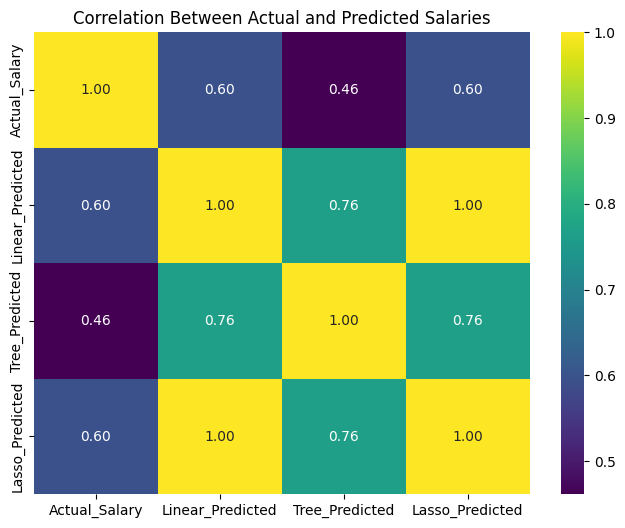

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#  prediction correlation
linreg_pred = linreg.predict(X_test)
tree_pred = tree_model.predict(X_test)
lasso_pred = lasso.predict(X_test)

# Build DataFrame
comparison_df = pd.DataFrame({
    'Actual_Salary': y_test,
    'Linear_Predicted': linreg_pred,
    'Tree_Predicted': tree_pred,
    'Lasso_Predicted': lasso_pred
})

# Correlation matrix for Actual vs Predictions
corr_predictions = comparison_df.corr()

# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(corr_predictions, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Between Actual and Predicted Salaries')
plt.show()


In [ ]:
# Predict using each model
linreg_pred = linreg.predict(X_test)
tree_pred = tree_model.predict(X_test)
lasso_pred = lasso.predict(X_test)

# Evaluate each model
linreg_rmse = np.sqrt(mean_squared_error(y_test, linreg_pred))
linreg_r2 = r2_score(y_test, linreg_pred)

tree_rmse = np.sqrt(mean_squared_error(y_test, tree_pred))
tree_r2 = r2_score(y_test, tree_pred)

lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)

# Print side-by-side results
print(f"Linear Regression -> RMSE: {linreg_rmse:.2f}, R²: {linreg_r2:.3f}")
print(f"Decision Tree -> RMSE: {tree_rmse:.2f}, R²: {tree_r2:.3f}")
print(f"Lasso Regression -> RMSE: {lasso_rmse:.2f}, R²: {lasso_r2:.3f}")



Linear Regression -> RMSE: 66652.85, R²: 0.354
Decision Tree -> RMSE: 79853.80, R²: 0.072
Lasso Regression -> RMSE: 66652.25, R²: 0.354


In [ ]:
import pickle

# Save the trained Lasso model
filename = '/content/lasso_salary_model.pkl'   # Save directly to /content/ folder
pickle.dump(lasso, open(filename, 'wb'))

# (Optional) Load the model back to test
loaded_model = pickle.load(open(filename, 'rb'))

# (Optional) Confirm the model loads and scores the same
print(f"Loaded model test R²: {loaded_model.score(X_test, y_test):.3f}")


Loaded model test R²: 0.354


In [ ]:
from google.colab import files

# Download the saved Lasso model
files.download('/content/lasso_salary_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>